# Ecommerce Payment method analysis
## Description
Payment instrument is a crucial part of shopping online and can provide crucial insights for multiple purposes:
1. Personalized Customer Experience:
  a. Tailored payment options: Offer payment methods that align with customer preferences and demographics, improving user satisfaction and conversion rates.
  b. Reduced friction: Avoid presenting irrelevant payment options, streamlining the checkout process and minimizing abandoned carts.
2. Fraud Prevention:
  a. Risk assessment: Identify high-risk transactions based on payment method and customer behavior patterns, helping to detect and prevent fraudulent activity.
  b. Anomaly detection: Flag unusual payment choices that deviate from customer norms, alerting merchants to potential fraud attempts.
3. Marketing and Promotions:
  a. Targeted campaigns: Design marketing campaigns that resonate with specific payment method segments, increasing the effectiveness of promotions.
  b. Offer optimization: Tailor promotional offers to the preferred payment methods of customers, maximizing their appeal and redemption rates.
4. Inventory Management:
  a. Demand forecasting: Predict payment method usage to anticipate product demand and optimize inventory levels accordingly.
  b. Supply chain management: Ensure adequate supply of products to meet demand, avoiding stockouts or excess inventory.
5. Payment Infrastructure Optimization:
  a. Cost management: Evaluate the profitability of different payment methods to allocate resources effectively and minimize processing costs.
  b. Gateway selection: Select payment gateways that align with customer preferences and business objectives, ensuring a smooth and efficient checkout experience.

## Business Objective
**Predict the payment method for an order**

Identify the features influencing the payment method of a customer for a particular order and develop a method to predict the payment method.

## Dataset
Source: https://www.kaggle.com/datasets/bytadit/ecommerce-order-dataset
The E-commerce Order Dataset provides comprehensive information related to orders, items within orders, customers, payments, and products for an e-commerce platform for a sample of about 89K orders on an ecommerce platform. This dataset is structured with multiple tables, each containing specific information about various aspects of the e-commerce operations.

### Orders Table:
* order_id: Unique identifier for an order, acting as the primary key.
* customer_id: Unique identifier for a customer. This table may not be unique at this level.
* order_status: Indicates the status of an order (e.g., delivered, cancelled, processing, etc.).
* order_purchase_timestamp: Timestamp when the order was made by the customer.
* order_approved_at: Timestamp when the order was approved from the seller's side.
* order_delivered_timestamp: Timestamp when the order was delivered at the customer's location.
* order_estimated_delivery_date: Estimated date of delivery shared with the customer while placing the order.

### Order Items Table
* order_id: Unique identifier for an order.
* order_item_id: Item number in each order, acting as part of the primary key along with the order_id.
* product_id: Unique identifier for a product.
* seller_id: Unique identifier for the seller.
* price: Selling price of the product.
* shipping_charges: Charges associated with the shipping of the product.

### Customers Table
* customer_id: Unique identifier for a customer, acting as the primary key.
* customer_zip_code_prefix: Customer's Zip code.
* customer_city: Customer's city.
* customer_state: Customer's state.

### Payments Table
* order_id: Unique identifier for an order.
* payment_sequential: Provides information about the sequence of payments for the given order.
* payment_type: Type of payment (e.g., credit_card, debit_card, etc.).
* payment_installments: Payment installment number in case of credit cards.
* payment_value: Transaction value.

### Products Table
* product_id: Unique identifier for each product, acting as the primary key.
* product_category_name: Name of the category the product belongs to.
* product_weight_g: Product weight in grams.
* product_length_cm: Product length in centimeters.
* product_height_cm: Product height in centimeters.
* product_width_cm: Product width in centimeters.



## Import modules and data

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import joblib
import os
from datetime import datetime, timedelta, time
# import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, roc_curve, make_scorer, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # displays all columns (wrap-around) in pandas statistics

In [120]:
file_paths = {
    "orders_train": "train/df_Orders.csv",
    "customers_train": "train/df_Customers.csv",
    "products_train": "train/df_Products.csv",
    "payments_train": "train/df_Payments.csv",
    "order_items_train": "train/df_OrderItems.csv",
    "orders_test": "test/df_Orders.csv",
    "customers_test": "test/df_Customers.csv",
    "products_test": "test/df_Products.csv",
    "payments_test": "test/df_Payments.csv",
    "order_items_test": "test/df_OrderItems.csv",
}

# Load datasets
df_orders_train = pd.read_csv(file_paths["orders_train"])
df_customers_train = pd.read_csv(file_paths["customers_train"])
df_products_train = pd.read_csv(file_paths["products_train"])
df_payments_train = pd.read_csv(file_paths["payments_train"])
df_order_items_train = pd.read_csv(file_paths["order_items_train"])

df_orders_test = pd.read_csv(file_paths["orders_test"])
df_customers_test = pd.read_csv(file_paths["customers_test"])
df_products_test = pd.read_csv(file_paths["products_test"])
df_payments_test = pd.read_csv(file_paths["payments_test"])
df_order_items_test = pd.read_csv(file_paths["order_items_test"])

# Display the first few rows of each dataframe to understand the structure
print("Orders (Train):")
display(df_orders_train.head())

print("Customers (Train):")
display(df_customers_train.head())

print("Products (Train):")
display(df_products_train.head())

print("Payments (Train):")
display(df_payments_train.head())

print("Order Items (Train):")
display(df_order_items_train.head())

Orders (Train):


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09
1,v6px92oS8cLG,PxA7fv9spyhx,delivered,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24
2,Ulpf9skrhjfm,g3nXeJkGI0Qw,delivered,2018-02-16 16:19:31,2018-02-17 16:15:35,2018-02-27 01:29:50,2018-03-08
3,bwJVWupf2keN,EOEsCQ6QlpIg,delivered,2018-08-18 18:04:29,2018-08-18 18:15:16,2018-08-27 20:03:51,2018-09-19
4,Dd0QnrMk9Cj5,mVz5LO2Vd6cL,delivered,2017-12-22 16:44:04,2017-12-22 17:31:31,2018-01-05 19:22:49,2018-01-18


Customers (Train):


,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,hCT0x9JiGXBQ,58125,varzea paulista,SP
1,PxA7fv9spyhx,3112,armacao dos buzios,RJ
2,g3nXeJkGI0Qw,4119,jandira,SP
3,EOEsCQ6QlpIg,18212,uberlandia,MG
4,mVz5LO2Vd6cL,88868,ilhabela,SP


Products (Train):


,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,90K0C1fIyQUf,toys,491.0,19.0,12.0,16.0
1,qejhpMGGVcsl,watches_gifts,440.0,18.0,14.0,17.0
2,qUS5d2pEAyxJ,costruction_tools_garden,2200.0,16.0,16.0,16.0
3,639iGvMyv0De,toys,1450.0,68.0,3.0,48.0
4,1lycYGcsic2F,toys,300.0,17.0,4.0,12.0


Payments (Train):


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,Axfy13Hk4PIk,1,credit_card,1,259.14
1,v6px92oS8cLG,1,credit_card,8,382.39
2,Ulpf9skrhjfm,1,credit_card,4,249.25
3,bwJVWupf2keN,1,credit_card,2,27.79
4,Dd0QnrMk9Cj5,1,credit_card,1,76.15


Order Items (Train):


,order_id,product_id,seller_id,price,shipping_charges
0,Axfy13Hk4PIk,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65
1,v6px92oS8cLG,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79
2,Ulpf9skrhjfm,qUS5d2pEAyxJ,77p2EYxcM9MD,64.40,17.38
3,bwJVWupf2keN,639iGvMyv0De,jWzS0ayv9TGf,264.50,30.72
4,Dd0QnrMk9Cj5,1lycYGcsic2F,l1pYW6GBnPMr,779.90,30.66


## Data inspection

### Difference between train and test datasets

In [121]:
# Inspecting for missing columns in test vs training dataset

def column_sets(orders, customers, products, payments, order_items):
    return set(
        orders.columns.to_list() +
        customers.columns.to_list() +
        products.columns.to_list() +
        payments.columns.to_list() +
        order_items.columns.to_list()
    )

def print_proportion(dataset_name, train, test):
    tr_size = len(train)
    ts_size = len(test)
    print(f'{dataset_name}: train={tr_size*100.0/(tr_size+ts_size)}%, test={ts_size*100.0/(tr_size+ts_size)}%, training_size={tr_size}, total={ts_size+tr_size}')


print("Columns which exist in training dataset but not in test")
print(set.difference(
    column_sets(df_orders_train, df_customers_train, df_products_train, df_payments_train, df_order_items_train),
    column_sets(df_orders_test, df_customers_test, df_products_test, df_payments_test, df_order_items_test)
))

print("\nProportion of training and test")
print_proportion('Orders', df_orders_train, df_orders_test)
print_proportion('Customers', df_customers_train, df_customers_test)
print_proportion('Products', df_products_train, df_products_test)
print_proportion('Payments', df_payments_train, df_payments_test)
print_proportion('Orders Items', df_order_items_train, df_order_items_test)

Columns which exist in training dataset but not in test
{'order_status', 'order_estimated_delivery_date', 'order_delivered_timestamp'}

Proportion of training and test
Orders: train=69.99960813511501%, test=30.00039186488499%, training_size=89316, total=127595
Customers: train=69.99960813511501%, test=30.00039186488499%, training_size=89316, total=127595
Products: train=69.99960813511501%, test=30.00039186488499%, training_size=89316, total=127595
Payments: train=69.99960813511501%, test=30.00039186488499%, training_size=89316, total=127595
Orders Items: train=69.99960813511501%, test=30.00039186488499%, training_size=89316, total=127595


**Insights:**
* The whole dataset is split 70:30 between training and test
* Test dataset doesn't have 3 columns / features which are present in training dataset
* We have 2 approaches
  * Ignore the whole set of test datasets and use just training datasets to create test train splits
  * Drop the 3 columns from the training dataset to keep it in sync with test dataset
* Decision: we would go ahead and ignore the test dataset

### Inspecting data

In [122]:
# function printing number of null values and unique values per column
def print_df_info(df):
    print("total rows={}".format(len(df)))
    rows = []
    for col in df:
        num_unique = df[col].unique().size
        unique_values = (
            df[col].unique()
            if num_unique < 20
            else np.random.choice(df[col].unique(), 10)
        )
        rows.append(
            [
                col,
                df[col].dtypes,
                df[col].isnull().sum(),
                df[col].unique().size,
                # unique_values,
            ]
        )

    print(pd.DataFrame(rows, columns=["column", "dtype", "num_null", "num_unique"]))
    
    print("Duplicate values:")
    print(df.duplicated().sum())


print("\nOrders (Train):")
print_df_info(df_orders_train)

print("\nCustomers (Train):")
print_df_info(df_customers_train)

print("\nProducts (Train):")
print_df_info(df_products_train)

print("\nPayments (Train):")
print_df_info(df_payments_train)

print("\nOrder Items (Train):")
print_df_info(df_order_items_train)

# print("\nOrders (Test):")
# print_df_info(df_orders_test)

# print("\nCustomers (Test):")
# print_df_info(df_customers_test)

# print("\nProducts (Test):")
# print_df_info(df_products_test)

# print("\nPayments (Test):")
# print_df_info(df_payments_test)

# print("\nOrder Items (Test):")
# print_df_info(df_order_items_test)


Orders (Train):
total rows=89316
                          column   dtype  num_null  num_unique
0                       order_id  object         0       89316
1                    customer_id  object         0       89316
2                   order_status  object         0           7
3       order_purchase_timestamp  object         0       72775
4              order_approved_at  object         9       68216
5      order_delivered_timestamp  object      1889       71144
6  order_estimated_delivery_date  object         0         444
Duplicate values:
0

Customers (Train):
total rows=89316
                     column   dtype  num_null  num_unique
0               customer_id  object         0       89316
1  customer_zip_code_prefix   int64         0       13930
2             customer_city  object         0        3735
3            customer_state  object         0          27
Duplicate values:
0

Products (Train):
total rows=89316
                  column    dtype  num_null  num_unique
0  

#### Orders dataset

In [123]:
df_orders_train.info()
print(df_orders_train.duplicated(subset=["order_id"]).value_counts())
print(df_orders_train.duplicated(subset=["customer_id"]).value_counts())
df_orders_train.head()
print_df_info(df_orders_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       89316 non-null  object
 1   customer_id                    89316 non-null  object
 2   order_status                   89316 non-null  object
 3   order_purchase_timestamp       89316 non-null  object
 4   order_approved_at              89307 non-null  object
 5   order_delivered_timestamp      87427 non-null  object
 6   order_estimated_delivery_date  89316 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB
False    89316
Name: count, dtype: int64
False    89316
Name: count, dtype: int64
total rows=89316
                          column   dtype  num_null  num_unique
0                       order_id  object         0       89316
1                    customer_id  object         0       89316
2                   order_status 

Insights:
* All rows have unique customer_ids. Hence, this can be merged with customers dateset
* Following columns are unnecessary
  * order_approved_at
  * order_delivered_timestamp
  * order_estimated_delivery_date
  * order_status: since it becomes relevant after the payment is made
* [Feature engineering] However, we can create following 3 columns from order_purchase_timestamp
  * order_purchase_hour
  * order_purchase_day
  * order_purchase_month
  * estimated_delivery_duration_days
* After merge the ID columns can be dropped from the training datasets as those will be not useful

#### Customers dataset

In [124]:
df_customers_train.info()
print(df_customers_train.duplicated(subset=["customer_id"]).value_counts())
print(df_customers_train["customer_city"].unique().size)
print(df_customers_train["customer_state"].unique().size)
print(df_customers_train["customer_zip_code_prefix"].unique().size)
print("sample of customer zip code prefix")
print(df_customers_train["customer_zip_code_prefix"].sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               89316 non-null  object
 1   customer_zip_code_prefix  89316 non-null  int64 
 2   customer_city             89316 non-null  object
 3   customer_state            89316 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB
False    89316
Name: count, dtype: int64
3735
27
13930
sample of customer zip code prefix
40568    69307
9129     45840
71120     2943
17004     8773
11034    44006
85918     9050
2038     49075
23104    39780
66278    47700
11566    11082
Name: customer_zip_code_prefix, dtype: int64


Insights
* This can be merged with orders dataset and the id columns can be discarded later

#### Products dataset

In [125]:
print(df_products_train.info())
# removing duplicates from products dataset
# df_products_train = df_products_train.drop_duplicates()
print_df_info(df_products_train)
print(df_products_train["product_category_name"].unique().size)
print(df_products_train["product_category_name"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             89316 non-null  object 
 1   product_category_name  89008 non-null  object 
 2   product_weight_g       89301 non-null  float64
 3   product_length_cm      89301 non-null  float64
 4   product_height_cm      89301 non-null  float64
 5   product_width_cm       89301 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.1+ MB
None
total rows=89316
                  column    dtype  num_null  num_unique
0             product_id   object         0       27451
1  product_category_name   object       308          71
2       product_weight_g  float64        15        2021
3      product_length_cm  float64        15         100
4      product_height_cm  float64        15         102
5       product_width_cm  float64        15          94
Duplicate 

Insights:
* We can remove the duplicate rows from the dataset
* Marginal number of rows have product_category_name as nan
  * We would still keep them in case some of those products are very popular
* We can feature engineer and modify column product weight and assigned 3 values light, medium, heavy
* We can have new column called product volume and assign 3 values small, medium, large

#### Order items dataset

In [126]:
print(df_order_items_train.info())
print(df_order_items_train.duplicated(subset=["order_id"]).value_counts())
print(df_order_items_train.duplicated(subset=["product_id"]).value_counts())
print(df_order_items_train.duplicated(subset=["seller_id"]).value_counts())
print_df_info(df_order_items_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          89316 non-null  object 
 1   product_id        89316 non-null  object 
 2   seller_id         89316 non-null  object 
 3   price             89316 non-null  float64
 4   shipping_charges  89316 non-null  float64
dtypes: float64(2), object(3)
memory usage: 3.4+ MB
None
False    89316
Name: count, dtype: int64
True     61865
False    27451
Name: count, dtype: int64
True     86387
False     2929
Name: count, dtype: int64
total rows=89316
             column    dtype  num_null  num_unique
0          order_id   object         0       89316
1        product_id   object         0       27451
2         seller_id   object         0        2929
3             price  float64         0        5235
4  shipping_charges  float64         0        6327
Duplicate values:
0


Insights:
* This dataset can be merged with orders dataset and products dataset
* Once merged, the id columns, except seller_id, can be dropped. Seller_id has just 2929 unique items.

#### Payments dataset

In [127]:
print(df_payments_train.info())
print(df_payments_train.duplicated(subset=["order_id"]).value_counts())
print(df_payments_train["payment_type"].unique())
print(df_payments_train["payment_sequential"].unique())
print(df_payments_train["payment_installments"].unique())

# df_payments_train["payment_value"].hist(
#     column="payment_value", bins=500, figsize=(15, 8)
# )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              89316 non-null  object 
 1   payment_sequential    89316 non-null  int64  
 2   payment_type          89316 non-null  object 
 3   payment_installments  89316 non-null  int64  
 4   payment_value         89316 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.4+ MB
None
False    89316
Name: count, dtype: int64
['credit_card' 'wallet' 'voucher' 'debit_card']
[ 1  8  2  6  3  4  9  5 23 11 18 10  7 12 13 26 15 14 17 24 21 20 16 19
 22 29 25 28]
[ 1  8  4  2  5  6 10  3  7  9 18 12 24 15 11 13 21 16 20 14 17 23 22  0]


Insights:
* Since all orders are unique, this can be merged with the orders table as well

## Data preparation

### Merge datasets

In [128]:
def merge_datasets(df_orders, df_order_items, df_customers, df_products, df_payments):
    return (
        df_orders.merge(df_order_items, on="order_id", how="outer")
        .merge(df_customers, on="customer_id", how="outer")
        .merge(df_products, on="product_id", how="outer")
        .merge(df_payments, on="order_id", how="outer")
    )

In [129]:
# merge training datasets
df = merge_datasets(
    df_orders_train,
    df_order_items_train,
    df_customers_train,
    df_products_train,
    df_payments_train,
)
df.info()
print_df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2529486 entries, 0 to 2529485
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   order_id                       object 
 1   customer_id                    object 
 2   order_status                   object 
 3   order_purchase_timestamp       object 
 4   order_approved_at              object 
 5   order_delivered_timestamp      object 
 6   order_estimated_delivery_date  object 
 7   product_id                     object 
 8   seller_id                      object 
 9   price                          float64
 10  shipping_charges               float64
 11  customer_zip_code_prefix       int64  
 12  customer_city                  object 
 13  customer_state                 object 
 14  product_category_name          object 
 15  product_weight_g               float64
 16  product_length_cm              float64
 17  product_height_cm              float64
 18  pr

### Data cleaning and feature engineering

In [130]:
## write functions per individual dataset for data cleaning and feature engineering

def transform_dataset(df):
    df[[
        "order_purchase_timestamp",
        "order_estimated_delivery_date"
    ]] = df[[
        "order_purchase_timestamp",
        "order_estimated_delivery_date"
    ]].apply(pd.to_datetime)

    # Adding new features
    df["order_purchase_hour"] = df['order_purchase_timestamp'].dt.hour
    df["order_purchase_day"] = df['order_purchase_timestamp'].dt.dayofweek
    df["order_purchase_month"] = df['order_purchase_timestamp'].dt.month
    df["estimated_delivery_duration_days"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.days
    
    # dropping 
    df.drop(
        columns=[
            "order_status",
            "order_purchase_timestamp",
            "order_approved_at",
            "order_delivered_timestamp",
            "order_estimated_delivery_date",
        ],
        inplace=True,
    )
    df['prod_vol'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
    
    # Add a new column called vol_category with 3 values: small: 1, medium: 2 and large: 3
    vol_p25 = df['prod_vol'].quantile([0.25]).values[0]
    vol_p75 = df['prod_vol'].quantile([0.75]).values[0]
    df['vol_category'] = df['prod_vol'].apply(lambda x: 3 if x>=vol_p75 else (2 if x>=vol_p25 and x<vol_p75 else 1))
    
    # Add a new column called weight_category with 3 values: light: 1, medium: 2 and heavy: 3
    wt_p25 = df['product_weight_g'].quantile([0.25]).values[0]
    wt_p75 = df['product_weight_g'].quantile([0.75]).values[0]
    df['weight_category'] = df['product_weight_g'].apply(lambda x: 3 if x>=wt_p75 else (2 if x>=wt_p25 and x<wt_p75 else 1))

    # Drop order_id, customer_id and product_id columns as these are not necessary after merging
    df.drop(columns=["order_id", "customer_id", "product_id"], inplace=True)
    
    df.drop_duplicates(inplace=True)

In [131]:
# transform train dataset
transform_dataset(df)
df.head()

,seller_id,price,shipping_charges,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_hour,order_purchase_day,order_purchase_month,estimated_delivery_duration_days,prod_vol,vol_category,weight_category
0,ZWM05J9LcBSF,223.51,84.65,58125,varzea paulista,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,1,259.14,18,6,10,17,3648.0,1,2
13,ZWM05J9LcBSF,223.51,48.35,17515,rio de janeiro,RJ,toys,491.0,19.0,12.0,16.0,1,wallet,1,294.17,17,0,10,16,3648.0,1,2
26,ZWM05J9LcBSF,223.51,84.65,40286,aracatuba,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,7,259.14,11,6,10,18,3648.0,1,2
39,ZWM05J9LcBSF,223.51,84.65,88130,araraquara,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,1,259.14,16,0,10,16,3648.0,1,2
52,ZWM05J9LcBSF,223.51,45.50,2976,cuiaba,MT,toys,491.0,19.0,12.0,16.0,1,credit_card,1,188.63,16,3,10,27,3648.0,1,2


In [132]:
df.dropna(subset=["prod_vol","product_category_name"], inplace=True)

In [133]:
# it seems removing the various id columns resulted in lots of duplicates. Dropping those duplicates now
df.drop_duplicates(inplace=True)
print_df_info(df)
df.info()

total rows=78001
                              column    dtype  num_null  num_unique
0                          seller_id   object         0        2921
1                              price  float64         0        5215
2                   shipping_charges  float64         0        6321
3           customer_zip_code_prefix    int64         0       13917
4                      customer_city   object         0        3730
5                     customer_state   object         0          27
6              product_category_name   object         0          70
7                   product_weight_g  float64         0        2019
8                  product_length_cm  float64         0          99
9                  product_height_cm  float64         0         101
10                  product_width_cm  float64         0          93
11                payment_sequential    int64         0          28
12                      payment_type   object         0           4
13              payment_install

In [134]:
# reseting the index
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78001 entries, 0 to 78000
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   seller_id                         78001 non-null  object 
 1   price                             78001 non-null  float64
 2   shipping_charges                  78001 non-null  float64
 3   customer_zip_code_prefix          78001 non-null  int64  
 4   customer_city                     78001 non-null  object 
 5   customer_state                    78001 non-null  object 
 6   product_category_name             78001 non-null  object 
 7   product_weight_g                  78001 non-null  float64
 8   product_length_cm                 78001 non-null  float64
 9   product_height_cm                 78001 non-null  float64
 10  product_width_cm                  78001 non-null  float64
 11  payment_sequential                78001 non-null  int64  
 12  paym

In [135]:
df.head()

,seller_id,price,shipping_charges,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_hour,order_purchase_day,order_purchase_month,estimated_delivery_duration_days,prod_vol,vol_category,weight_category
0,ZWM05J9LcBSF,223.51,84.65,58125,varzea paulista,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,1,259.14,18,6,10,17,3648.0,1,2
1,ZWM05J9LcBSF,223.51,48.35,17515,rio de janeiro,RJ,toys,491.0,19.0,12.0,16.0,1,wallet,1,294.17,17,0,10,16,3648.0,1,2
2,ZWM05J9LcBSF,223.51,84.65,40286,aracatuba,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,7,259.14,11,6,10,18,3648.0,1,2
3,ZWM05J9LcBSF,223.51,84.65,88130,araraquara,SP,toys,491.0,19.0,12.0,16.0,1,credit_card,1,259.14,16,0,10,16,3648.0,1,2
4,ZWM05J9LcBSF,223.51,45.50,2976,cuiaba,MT,toys,491.0,19.0,12.0,16.0,1,credit_card,1,188.63,16,3,10,27,3648.0,1,2


### Exploratory data analysis
#### Univariate analysis
##### Numeric features

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'shipping_charges'}>,
        <Axes: title={'center': 'customer_zip_code_prefix'}>,
        <Axes: title={'center': 'product_weight_g'}>],
       [<Axes: title={'center': 'product_length_cm'}>,
        <Axes: title={'center': 'product_height_cm'}>,
        <Axes: title={'center': 'product_width_cm'}>,
        <Axes: title={'center': 'payment_sequential'}>],
       [<Axes: title={'center': 'payment_installments'}>,
        <Axes: title={'center': 'payment_value'}>,
        <Axes: title={'center': 'order_purchase_hour'}>,
        <Axes: title={'center': 'order_purchase_day'}>],
       [<Axes: title={'center': 'order_purchase_month'}>,
        <Axes: title={'center': 'estimated_delivery_duration_days'}>,
        <Axes: title={'center': 'prod_vol'}>,
        <Axes: title={'center': 'vol_category'}>],
       [<Axes: title={'center': 'weight_category'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

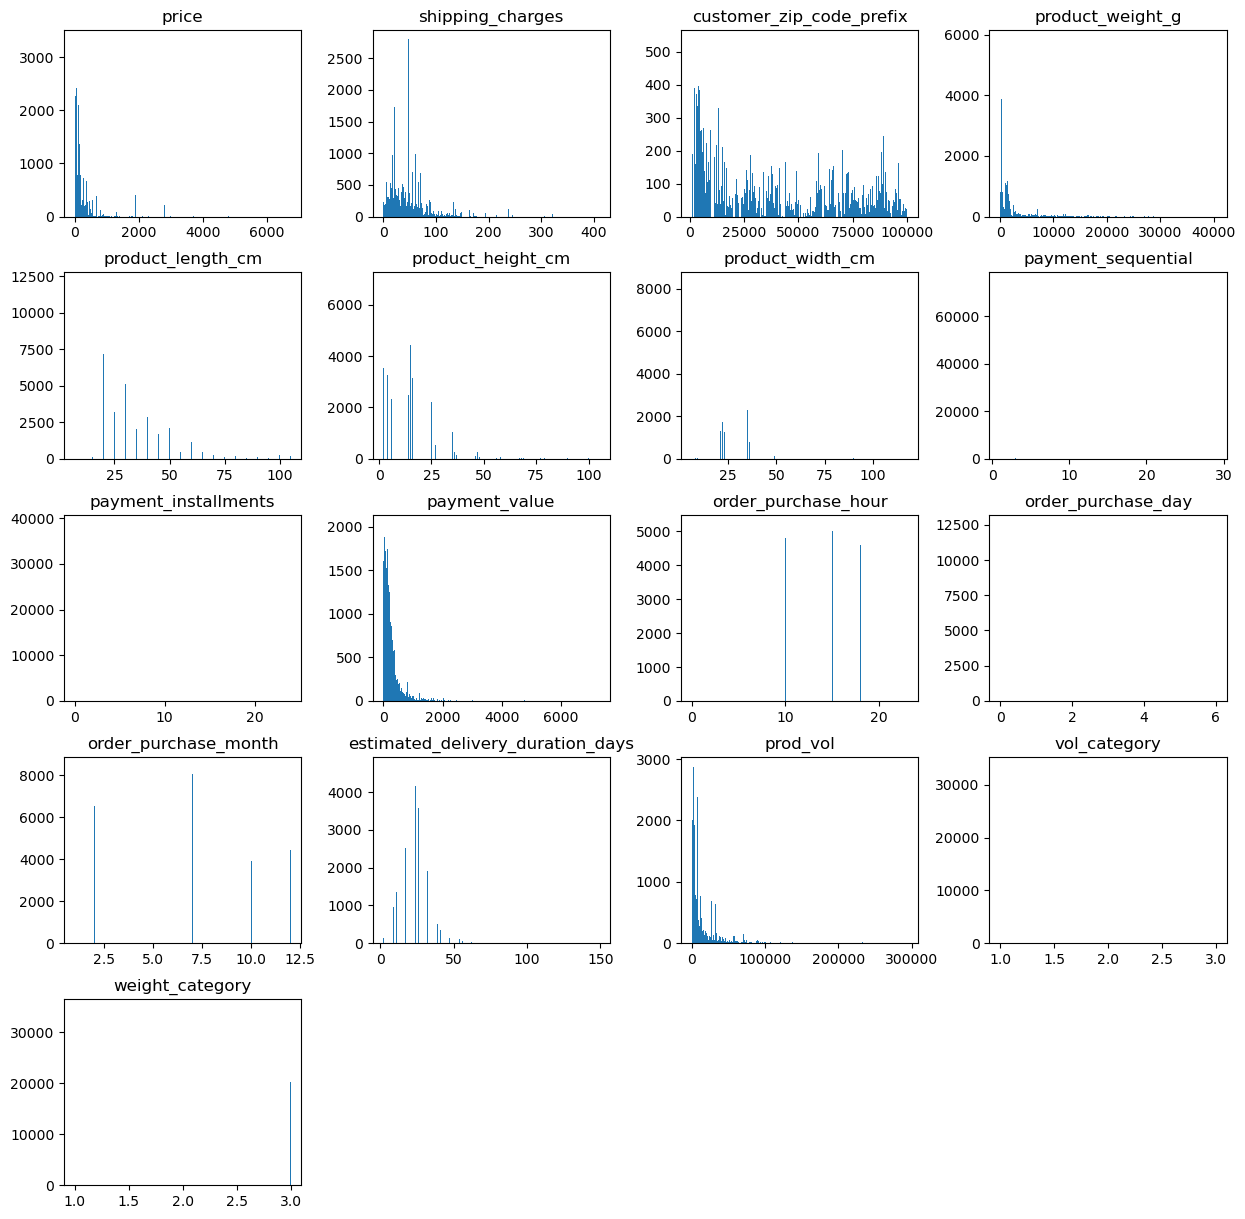

In [136]:
df.hist(figsize=(15, 15), grid=False, bins=1000)

##### Categorical features

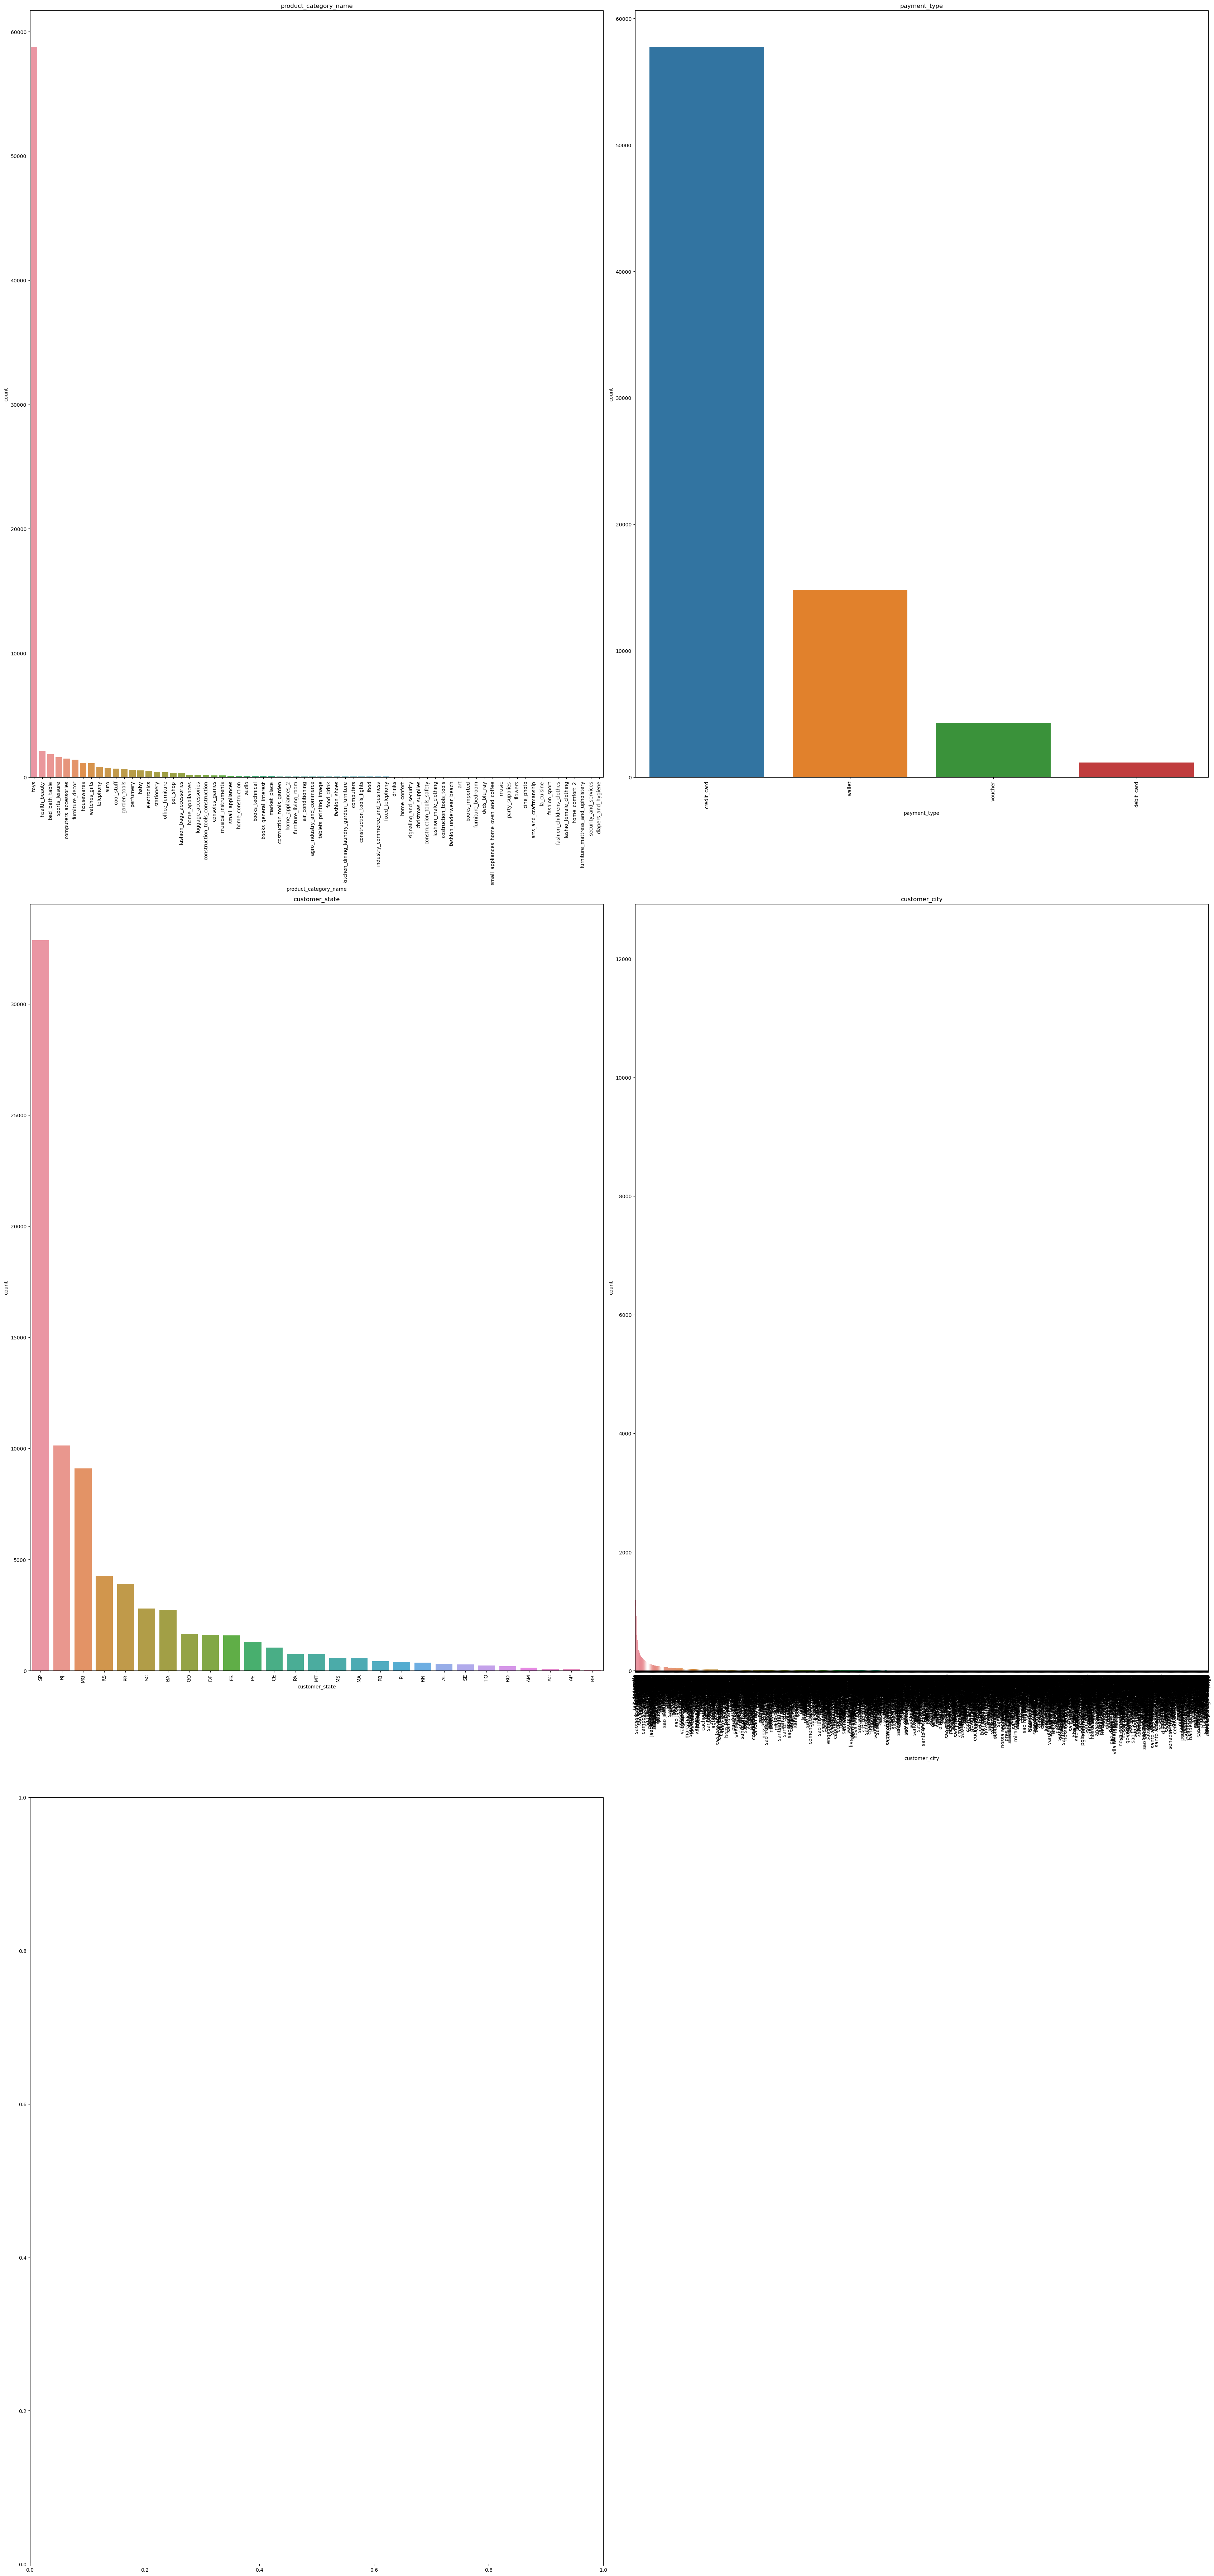

In [137]:
n_categories = 5
n_cols = 2
n_rows = n_categories // n_cols + (n_categories % n_cols > 0)
cat = df[
    [
        "product_category_name",
        "payment_type",
        "customer_state",
        "customer_city",
    ]
]
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 17, n_rows * 24))
axs = axs.flatten()
for i, column in enumerate(cat.columns):
    # Plot each category in its subplot
    sns.barplot(
        x=cat[column].value_counts().index, y=cat[column].value_counts(), ax=axs[i]
    )
    axs[i].set_title(column)
    # Get current x-tick labels and set them with a 90-degree rotation
    labels = axs[i].get_xticklabels()
    axs[i].set_xticklabels(labels, rotation=90)

for i in range(n_categories, len(axs)):
    axs[i].set_visible(False)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

### Correlation
#### Bivariate analysis

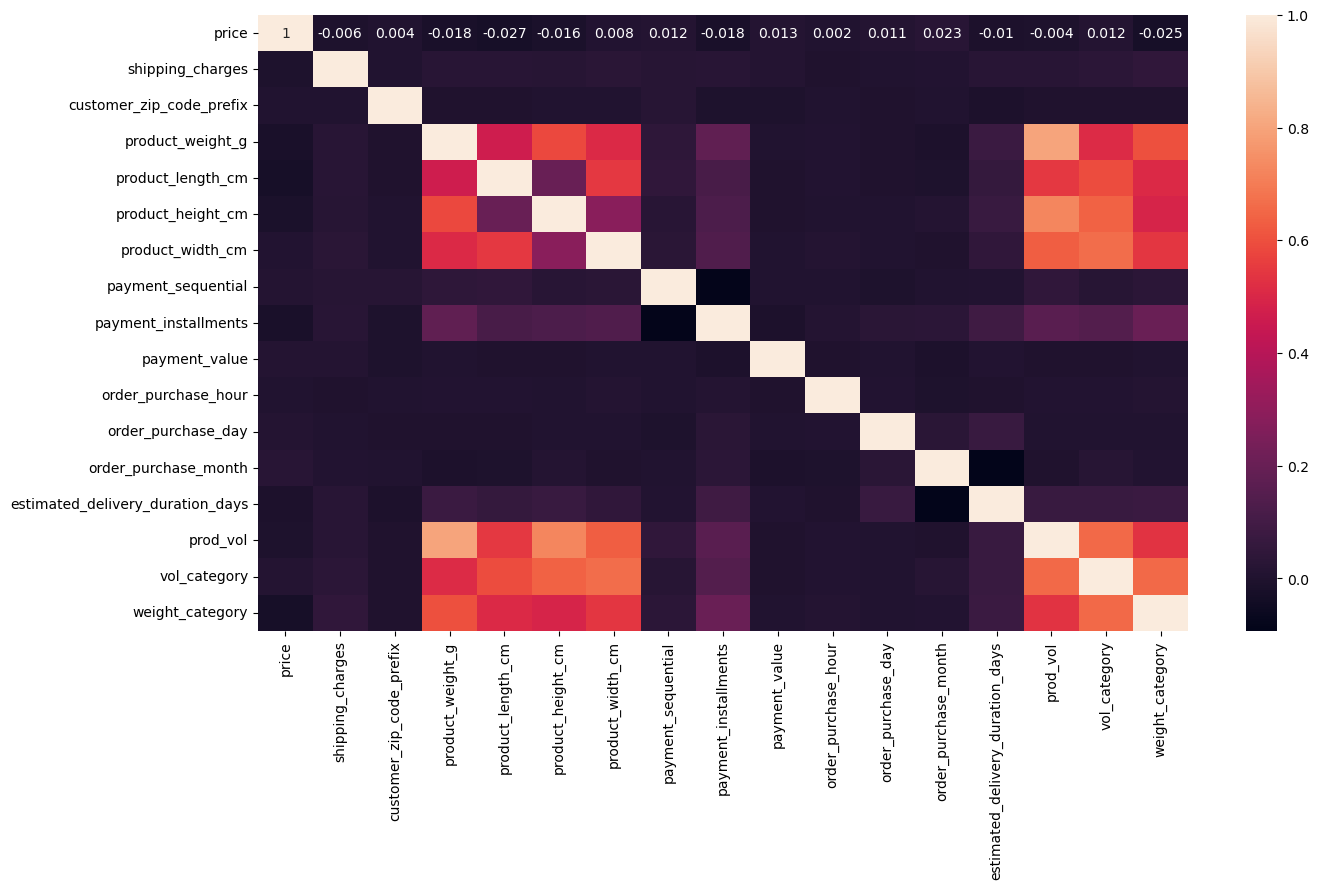

In [138]:
corr = df.corr(numeric_only = True).round(3)
plt.figure(figsize= (15,8))
sns.heatmap(corr, annot= True);

### Convert categorical data to numerical

In [139]:
label_encoder = OrdinalEncoder()
# df['customer_zip_code_prefix']= label_encoder.fit_transform(df['customer_zip_code_prefix'])
# df['customer_city']= label_encoder.fit_transform(df['customer_city'])
# df['customer_zip_code_prefix'] = label_encoder.fit_transform(df['customer_zip_code_prefix'])
# df['customer_zip_code_prefix'] = label_encoder.fit_transform(df['customer_zip_code_prefix'])

# custom_city = pd.concat([df['customer_city']])
# label_encoder.fit(custom_city)
# df['customer_city']= label_encoder.transform(df['customer_city'])

# custom_state = pd.concat([df['customer_state']])
# label_encoder.fit(custom_state)
# df['customer_state']= label_encoder.transform(df['customer_state'])

# sell_id = pd.concat([df['seller_id']])
# label_encoder.fit(sell_id)
# df['seller_id']= label_encoder.transform(df['seller_id'])

# cat_name = pd.concat([df['product_category_name']])
# label_encoder.fit(cat_name)
# df['product_category_name']= label_encoder.transform(df['product_category_name'])
df[[
    'customer_zip_code_prefix',
    'customer_city',
    'customer_state',
    'seller_id',
    'product_category_name',
]] = label_encoder.fit_transform(df[[
    'customer_zip_code_prefix',
    'customer_city',
    'customer_state',
    'seller_id',
    'product_category_name',
]])
print_df_info(df)

total rows=78001
                              column    dtype  num_null  num_unique
0                          seller_id  float64         0        2921
1                              price  float64         0        5215
2                   shipping_charges  float64         0        6321
3           customer_zip_code_prefix  float64         0       13917
4                      customer_city  float64         0        3730
5                     customer_state  float64         0          27
6              product_category_name  float64         0          70
7                   product_weight_g  float64         0        2019
8                  product_length_cm  float64         0          99
9                  product_height_cm  float64         0         101
10                  product_width_cm  float64         0          93
11                payment_sequential    int64         0          28
12                      payment_type   object         0           4
13              payment_install

In [140]:
df.head()

,seller_id,price,shipping_charges,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_hour,order_purchase_day,order_purchase_month,estimated_delivery_duration_days,prod_vol,vol_category,weight_category
0,1689.0,223.51,84.65,9152.0,3645.0,25.0,68.0,491.0,19.0,12.0,16.0,1,credit_card,1,259.14,18,6,10,17,3648.0,1,2
1,1689.0,223.51,48.35,4821.0,2844.0,18.0,68.0,491.0,19.0,12.0,16.0,1,wallet,1,294.17,17,0,10,16,3648.0,1,2
2,1689.0,223.51,84.65,7824.0,200.0,25.0,68.0,491.0,19.0,12.0,16.0,1,credit_card,7,259.14,11,6,10,18,3648.0,1,2
3,1689.0,223.51,84.65,12675.0,232.0,25.0,68.0,491.0,19.0,12.0,16.0,1,credit_card,1,259.14,16,0,10,16,3648.0,1,2
4,1689.0,223.51,45.50,732.0,1015.0,12.0,68.0,491.0,19.0,12.0,16.0,1,credit_card,1,188.63,16,3,10,27,3648.0,1,2


In [141]:
# print_df_info(df)

In [142]:
# df = pd.get_dummies(df, columns = ['order_status'])
# print_df_info(df)
# df.info()

In [143]:
# corr = df.corr(numeric_only = True).round(3)
# plt.figure(figsize= (15,8))
# sns.heatmap(corr, annot= True);

* We can remove payment_installments and payment_sequential columns as they have strong correlation with payment_type column

# Feature selection, modeling for payments_type target

## Feature Selection (RFE) including engineered features

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78001 entries, 0 to 78000
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   seller_id                         78001 non-null  float64
 1   price                             78001 non-null  float64
 2   shipping_charges                  78001 non-null  float64
 3   customer_zip_code_prefix          78001 non-null  float64
 4   customer_city                     78001 non-null  float64
 5   customer_state                    78001 non-null  float64
 6   product_category_name             78001 non-null  float64
 7   product_weight_g                  78001 non-null  float64
 8   product_length_cm                 78001 non-null  float64
 9   product_height_cm                 78001 non-null  float64
 10  product_width_cm                  78001 non-null  float64
 11  payment_sequential                78001 non-null  int64  
 12  paym

In [145]:
# target_feature = 'payment_type_credit_card'
target_feature = 'payment_type'
remove_features = [
#     'payment_type_debit_card',
#     'payment_type_wallet',
#     'payment_type_voucher',
    'payment_sequential',
    'payment_installments'
]

In [146]:
label_encoder = LabelEncoder()
df['payment_type']= label_encoder.fit_transform(df['payment_type'])

In [147]:
X = df.drop(columns=([target_feature]+remove_features))
y = df[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
numerical_features = [
    'price',
    'shipping_charges',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'prod_vol',
    'payment_value',
    'estimated_delivery_duration_days'
]

In [149]:

categorical_features = [
    'customer_zip_code_prefix',
    'customer_city',
    'customer_state',
    'seller_id',
    'product_category_name',
]

In [150]:
preprocessor = ColumnTransformer(
    [
        ("scaler", StandardScaler(), numerical_features),
        ("cat", OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['price', 'shipping_charges',
                                  'product_weight_g', 'product_length_cm',
                                  'product_height_cm', 'product_width_cm',
                                  'prod_vol', 'payment_value',
                                  'estimated_delivery_duration_days']),
                                ('cat', OrdinalEncoder(),
                                 ['customer_zip_code_prefix', 'customer_city',
                                  'customer_state', 'seller_id',
                                  'product_category_name'])])

In [151]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78001 entries, 0 to 78000
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   seller_id                         78001 non-null  float64
 1   price                             78001 non-null  float64
 2   shipping_charges                  78001 non-null  float64
 3   customer_zip_code_prefix          78001 non-null  float64
 4   customer_city                     78001 non-null  float64
 5   customer_state                    78001 non-null  float64
 6   product_category_name             78001 non-null  float64
 7   product_weight_g                  78001 non-null  float64
 8   product_length_cm                 78001 non-null  float64
 9   product_height_cm                 78001 non-null  float64
 10  product_width_cm                  78001 non-null  float64
 11  payment_value                     78001 non-null  float64
 12  orde

In [152]:
# Create the RFE object with LightGBM as the estimator
# and specifying the number of features to select
n_features_to_select = 10
rfe = RFE(estimator=lgb.LGBMRegressor(), n_features_to_select=n_features_to_select, step=1)

# Create a pipeline that includes preprocessing and RFE
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfe', rfe)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get the feature names after preprocessing
preprocessed_feature_names = [str(i).removeprefix('scaler__').removeprefix('remainder__').removeprefix('cat__') for i in pipeline.named_steps['preprocessor'].get_feature_names_out()]

# Extract the selected features from the preprocessed data
selected_features = [preprocessed_feature_names[i] for i in range(len(preprocessed_feature_names)) if pipeline.named_steps['rfe'].support_[i]]
print('Chosen best {num_features} features by RFE:'.format(num_features=n_features_to_select), selected_features)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 62400, number of used features: 19
[LightGBM] [Info] Start training from score 0.694087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2535
[LightGBM] [Info] Number of data points in the train set: 62400, number of used features: 18
[LightGBM] [Info] Start training from score 0.694087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [153]:
print_df_info(df)

total rows=78001
                              column    dtype  num_null  num_unique
0                          seller_id  float64         0        2921
1                              price  float64         0        5215
2                   shipping_charges  float64         0        6321
3           customer_zip_code_prefix  float64         0       13917
4                      customer_city  float64         0        3730
5                     customer_state  float64         0          27
6              product_category_name  float64         0          70
7                   product_weight_g  float64         0        2019
8                  product_length_cm  float64         0          99
9                  product_height_cm  float64         0         101
10                  product_width_cm  float64         0          93
11                payment_sequential    int64         0          28
12                      payment_type    int64         0           4
13              payment_install

Insights:
* The columns height, width, length aren't that useful as we have volumn of the product, will remove them
* Very few rows have nan values for product weight and volumn. We can drop those rows

In [154]:
df.drop(columns=[
    'product_length_cm', # highly correlated to volume category 
    'product_height_cm', # highly correlated to volume category 
    'product_width_cm', # highly correlated to volume category 
    'payment_installments', # set to a higher number only if payment_type (target) is credit card
    'payment_sequential', # different numbers only if payment_type (target) is credit card
    'prod_vol', # highly correlated to volume category 
    'product_weight_g', # highly correlated to weight category 
    'customer_city', # highly correlated to zipcode prefix
    'customer_state', # highly correlated to zipcode prefix
], inplace=True)

In [155]:
# df.fillna(value={"product_category_name":"unknown"}, inplace=True)
df.reset_index(drop=True, inplace=True)
print_df_info(df)
df.info()

total rows=78001
                              column    dtype  num_null  num_unique
0                          seller_id  float64         0        2921
1                              price  float64         0        5215
2                   shipping_charges  float64         0        6321
3           customer_zip_code_prefix  float64         0       13917
4              product_category_name  float64         0          70
5                       payment_type    int64         0           4
6                      payment_value  float64         0       25468
7                order_purchase_hour    int32         0          24
8                 order_purchase_day    int32         0           7
9               order_purchase_month    int32         0          12
10  estimated_delivery_duration_days    int64         0          96
11                      vol_category    int64         0           3
12                   weight_category    int64         0           3
Duplicate values:
565
<class 'p

#### Prep for Modeling

In [156]:
oenc = OrdinalEncoder()
df[[
    'customer_zip_code_prefix',
    'seller_id',
    'product_category_name',
]] = oenc.fit_transform(df[[
    'customer_zip_code_prefix',
    'seller_id',
    'product_category_name',
]])
target_feature = 'payment_type'
X = df.drop(columns=([target_feature]))
y = df[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(62400, 12)
(62400,)


In [157]:
numerical_features = [
    'price',
    'shipping_charges',
    'payment_value',
    'estimated_delivery_duration_days'
]
categorical_features = [
    'customer_zip_code_prefix',
#     'customer_city',
#     'customer_state',
    'seller_id',
    'product_category_name',
]
preprocessor = ColumnTransformer(
    [
        ("scaler", StandardScaler(), numerical_features),
#         ("cat", OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['price', 'shipping_charges', 'payment_value',
                                  'estimated_delivery_duration_days'])])

In [158]:
model_performance_df = pd.DataFrame(
    columns=['Model',
             'Train Time',
             'Train Accuracy %',
             'Test Accuracy %',
             'Train Recall %',
             'Test Recall %',
             'Train Precision %',
             'Test Precision %',
             'Train F1 %',
             'Test F1 %',
#              'Train ROC AUC %',
#              'Test ROC AUC %',
             'Train Log Loss',
             'Test Log Loss'
            ]
)

In [159]:
# Append model performance metrics to the DataFrame for the given model and return the updated DataFrame and also y_pred.
def populate_results(model_name, train_time, model, perf_df):
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    pd.Series(y_train_pred).unique()
    return pd.concat(
    [
        perf_df,
        pd.DataFrame([{
            'Model': model_name,
            'Train Time': train_time,
            'Train Accuracy %': accuracy_score(y_train, y_train_pred)*100,
            'Test Accuracy %': accuracy_score(y_test, y_pred)*100,
            'Train Recall %': recall_score(y_train, y_train_pred, average='macro')*100,
            'Test Recall %': recall_score(y_test, y_pred, average='macro')*100,
            'Train Precision %': precision_score(y_train, y_train_pred, average='macro')*100,
            'Test Precision %': precision_score(y_test, y_pred, average='macro')*100,
            'Train F1 %': f1_score(y_train, y_train_pred, average='macro')*100,
            'Test F1 %': f1_score(y_test, y_pred, average='macro')*100,
#             'Train ROC AUC %': roc_auc_score(y_train, y_train_pred, multi_class='ovr')*100,
#             'Test ROC AUC %': roc_auc_score(y_test, y_pred, multi_class='ovr')*100,
            'Train Log Loss': log_loss(y_train, y_train_pred_proba),
            'Test Log Loss': log_loss(y_test, y_pred_proba),
        }])
    ],
    ignore_index=True
    ), y_pred

#### Baseline model

In [160]:
# Establishing the baseline: most frequent class
baseline = y_train.value_counts(normalize=True)[0]
baseline

0.7406570512820513

In [161]:
predict_probas = {}
# List of models with with name, default pipeline and params when using GridSearchCV
# Note: Commenting initial version of hyperparms to save time during final runs.
models = [
    {
        'name': 'Logistic',
        'pipeline': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', LogisticRegression(solver='lbfgs', multi_class='auto', random_state=25, max_iter=10000, n_jobs=-1))]),
        'params': {
            'model__C': [0.01, 0.1, 1, 3, 5],
        }
    },
    {
        'name': 'KNN',
        'pipeline': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', KNeighborsClassifier())]),
        # 'params': {
        #     'model__n_neighbors': [3, 7, 11, 15, 19],
        #     'model__weights': ['uniform', 'distance']
        # },
        'params': {
            'model__n_neighbors': [3],
            'model__weights': ['distance']
        },
    },
    {
        'name': 'DecisionTree',
        'pipeline': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', DecisionTreeClassifier(random_state=25))]),
        # 'params': {
        #     'model__max_depth': [1, 5, 10, 15, 20],
        #     'model__criterion': ['gini', 'entropy'],
        #     'model__min_samples_split': [2, 3, 4, 5],
        #     'model__min_samples_leaf': [1, 2, 3, 4]
        # },
        'params': {
            'model__max_depth': [20, 25, 30, 35],
        },
    },
    {
        'name': 'RandomForest',
        'pipeline': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier(random_state=25, n_jobs=-1))]),
        # 'params': {
        #     'model__n_estimators': [100, 200, 300],
        #     'model__max_depth': [1, 5, 10, 15, 20],
        #     'model__min_samples_split': [1, 2, 3, 4],
        #     'model__min_samples_leaf': [2, 3, 4, 5],
        #     'model__max_features': ['log2', 'sqrt'],
        #     'model__bootstrap': [True, False],
        # },
        'params': {
            'model__max_depth': [20, 25, 30, 35],
            'model__min_samples_split': [1, 2, 3],
            'model__min_samples_leaf': [1, 2],
            'model__bootstrap': [False],
        },
    },
    {
        'name': 'GradientBoosting',
        'pipeline': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', GradientBoostingClassifier(random_state=25))]),
        # 'params': {
        #     'model__learning_rate': [0.01, 0.1, 0.2],
        #     'model__n_estimators': [100, 200, 300],
        #     'model__max_depth': [3, 5, 7],
        #     'model__min_samples_split': [2, 5, 10],
        #     'model__min_samples_leaf': [1, 2, 4],
        #     'model__subsample': [0.8, 0.9, 1.0],
        #     'model__max_features': ['auto', 'sqrt', 'log2'],
        # },
        'params': {
            'model__learning_rate': [0.2],
            'model__max_depth': [5, 7, 10],
            'model__min_samples_split': [20, 25, 30],
            'model__min_samples_leaf': [2],
        },
    },
    {
        'name': 'AdaBoost',
        'pipeline': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME',random_state=25))]),
        # 'params': {
        #     'model__n_estimators': [50, 100, 200],
        #     'model__learning_rate': [0.01, 0.1, 1.0],
        #     'model__estimator__max_depth': [1, 2, 3],
        #     'model__estimator__min_samples_split': [2, 5, 10],
        #     'model__estimator__min_samples_leaf': [1, 2, 4],
        # },
        'params': {
            'model__n_estimators': [50, 100],
            'model__estimator__max_depth': [5, 8, 11],
            'model__estimator__min_samples_leaf': [2],
        },
    },
    {
        'name': 'GaussianNB',
        'pipeline': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', GaussianNB())]),
    },
]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic training time: 45.98645210266113 secs
Logistic prediction and performance metrics time: 0.1552901268005371 secs


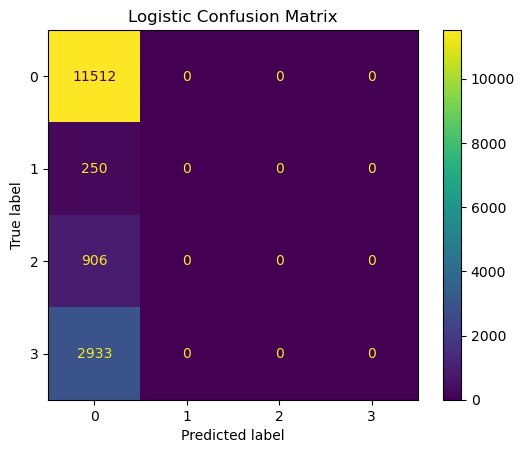

KNN training time: 0.03832817077636719 secs
KNN prediction and performance metrics time: 1.2751121520996094 secs


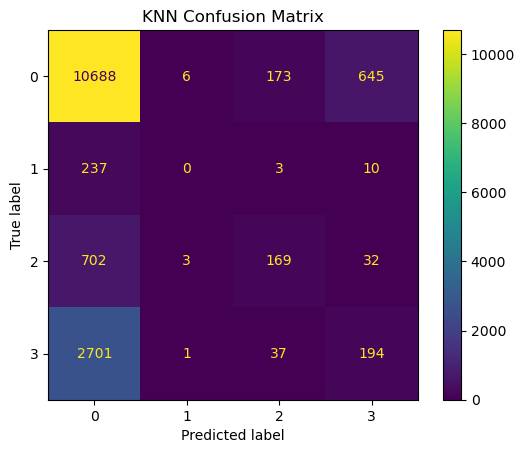

DecisionTree training time: 0.7269637584686279 secs
DecisionTree prediction and performance metrics time: 0.07999897003173828 secs


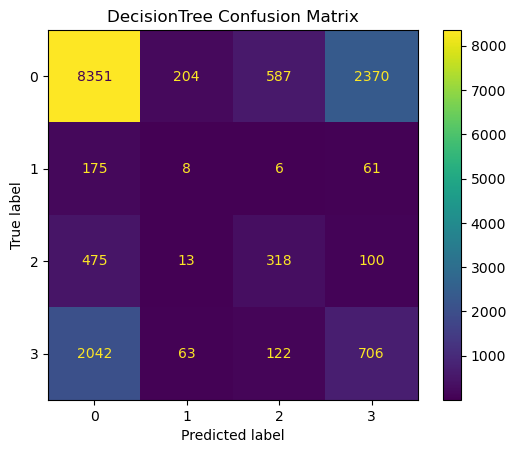

RandomForest training time: 2.37949800491333 secs
RandomForest prediction and performance metrics time: 0.5685131549835205 secs


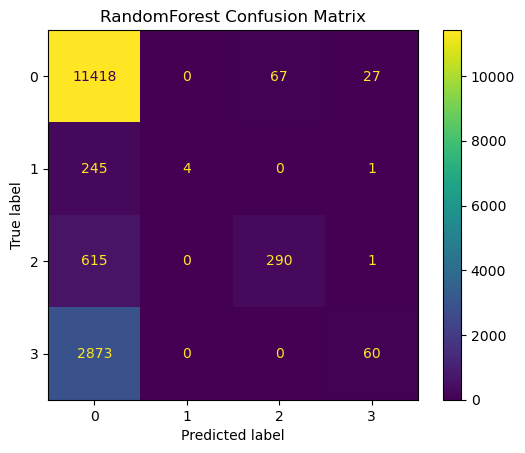

GradientBoosting training time: 32.80060887336731 secs
GradientBoosting prediction and performance metrics time: 0.5276029109954834 secs


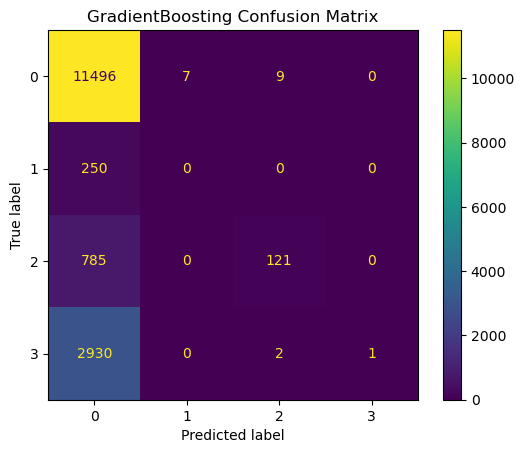

AdaBoost training time: 0.730222225189209 secs
AdaBoost prediction and performance metrics time: 0.08513689041137695 secs


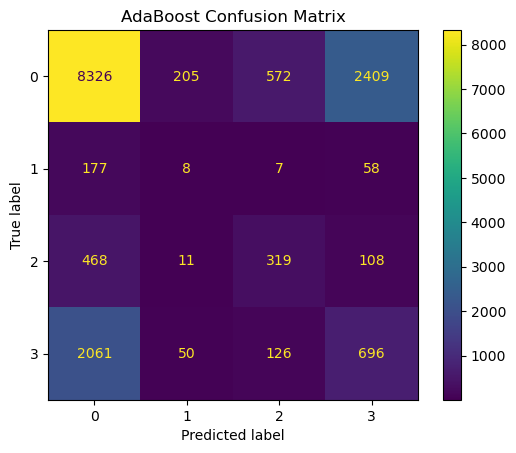

GaussianNB training time: 0.013768196105957031 secs
GaussianNB prediction and performance metrics time: 0.0658578872680664 secs


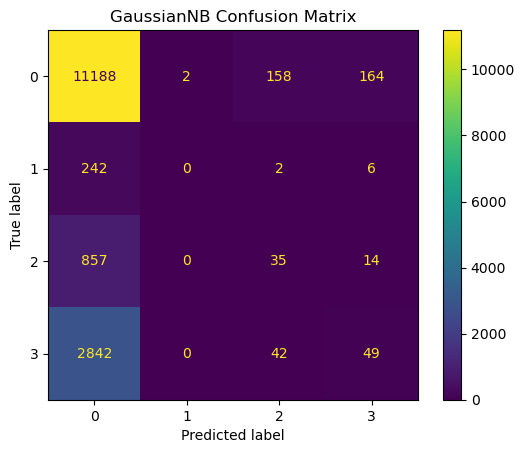

In [162]:
# Storing the pipelines from models to pipelines, to use this later for ROC curve and feature importance
pipelines = {}
# Running all the pipelines for each model in models.
for model in models:
    # storing the pipeline method in pipelines
    pipelines[model["name"]] = model['pipeline']
    start_time = time.time()
    pipelines[model["name"]].fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f'{model["name"]} training time: {train_time} secs')
    # Storing predict_proba for each model in predict_probas
    predict_probas[model["name"]] = pipelines[model["name"]].predict_proba(X_test)[:, 1]
    start_time = time.time()
    # Running populate_results to add perf data to model_performance_df
    model_performance_df, y_pred = populate_results(
        model['name'], train_time, pipelines[model["name"]], model_performance_df)
    print(f'{model["name"]} prediction and performance metrics time: {time.time() - start_time} secs')
    
    # Plot the confusion matrix in a new figure
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.title(f'{model["name"]} Confusion Matrix')
    plt.savefig(f'images/confusion_matrix_{model["name"]}.png')
    plt.show()

In [163]:
model_performance_df

,Model,Train Time,Train Accuracy %,Test Accuracy %,Train Recall %,Test Recall %,Train Precision %,Test Precision %,Train F1 %,Test F1 %,Train Log Loss,Test Log Loss
0,Logistic,45.986452,74.065705,73.790142,25.000000,25.000000,18.516426,18.447535,21.275215,21.229668,7.580308e-01,0.770026
1,KNN,0.038328,76.671474,70.835203,36.479798,29.527515,63.758846,35.214117,39.422522,29.784935,4.850140e-01,4.206654
2,DecisionTree,0.726964,100.000000,60.143581,100.000000,33.727988,100.000000,32.748697,100.000000,33.177354,2.220446e-16,14.365710
3,RandomForest,2.379498,99.998397,75.456701,99.999459,33.709494,99.992636,81.002396,99.996047,34.672417,1.663664e-01,0.860628
4,GradientBoosting,32.800609,74.921474,74.469585,29.580577,28.312629,89.589841,66.505374,29.434541,27.155757,7.049987e-01,0.739472
5,AdaBoost,0.730222,100.000000,59.925646,100.000000,33.616053,100.000000,32.705326,100.000000,33.103003,1.072796e+00,1.250904
6,GaussianNB,0.013768,72.483974,72.251779,26.055976,25.679831,28.484402,27.437167,23.898909,23.302616,8.204940e-01,0.826925


### Hyperparameter tuning

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase t

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic GridSearchCV training time: 332.64185404777527 secs
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['price', 'shipping_charges',
                                                   'payment_value',
                                                   'estimated_delivery_duration_days'])])),
                ('model',
                 LogisticRegression(C=3, max_iter=10000, multi_class='auto',
                                    n_jobs=-1, random_state=25))])
Logistic best model prediction and performance metrics time: 0.11529302597045898 secs


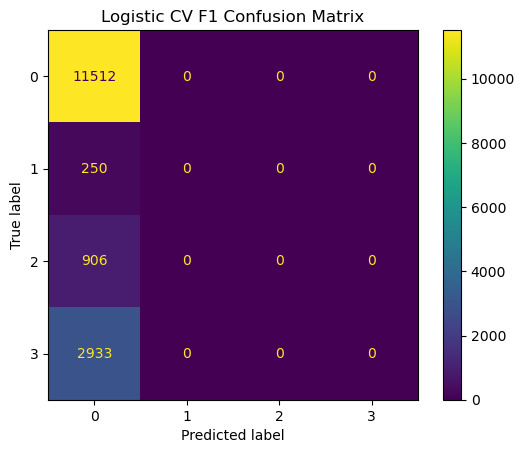

Fitting 5 folds for each of 1 candidates, totalling 5 fits
KNN GridSearchCV training time: 0.3854670524597168 secs
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['price', 'shipping_charges',
                                                   'payment_value',
                                                   'estimated_delivery_duration_days'])])),
                ('model',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])
KNN best model prediction and performance metrics time: 0.3907959461212158 secs


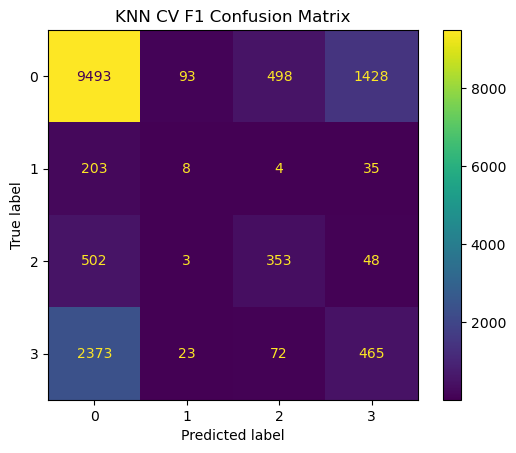

Fitting 5 folds for each of 4 candidates, totalling 20 fits
DecisionTree GridSearchCV training time: 3.056396007537842 secs
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['price', 'shipping_charges',
                                                   'payment_value',
                                                   'estimated_delivery_duration_days'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=35, random_state=25))])
DecisionTree best model prediction and performance metrics time: 0.08528494834899902 secs


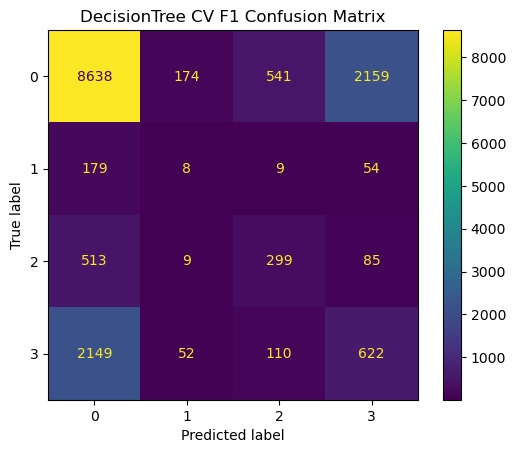

Fitting 5 folds for each of 24 candidates, totalling 120 fits
RandomForest GridSearchCV training time: 240.89731192588806 secs
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['price', 'shipping_charges',
                                                   'payment_value',
                                                   'estimated_delivery_duration_days'])])),
                ('model',
                 RandomForestClassifier(bootstrap=False, max_depth=35,
                                        n_jobs=-1, random_state=25))])
RandomForest best model prediction and performance metrics time: 0.9267499446868896 secs


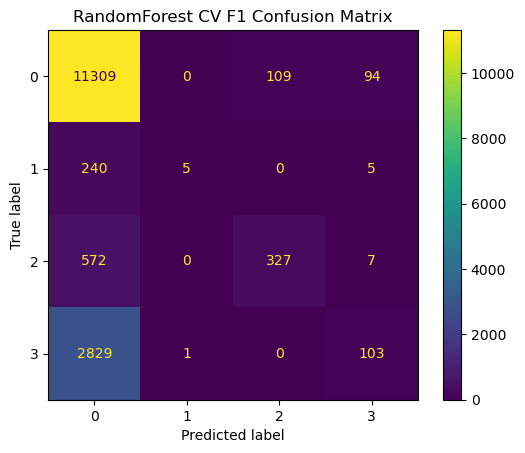

Fitting 5 folds for each of 9 candidates, totalling 45 fits
GradientBoosting GridSearchCV training time: 852.6527450084686 secs
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['price', 'shipping_charges',
                                                   'payment_value',
                                                   'estimated_delivery_duration_days'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=10,
                                            min_samples_leaf=2,
                                            min_samples_split=20,
                                            random_state=25))])
GradientBoosting best model prediction and performance metrics time: 1.5150537490844727 secs


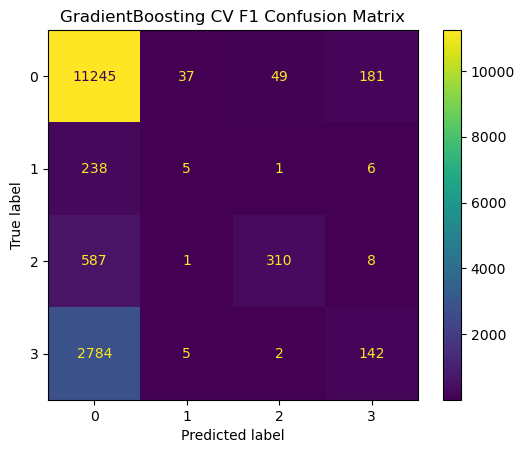

Fitting 5 folds for each of 6 candidates, totalling 30 fits
AdaBoost GridSearchCV training time: 126.68309688568115 secs
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['price', 'shipping_charges',
                                                   'payment_value',
                                                   'estimated_delivery_duration_days'])])),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=11,
                                                                     min_samples_leaf=2),
                                    n_estimators=100, random_state=25))])
AdaBoost best model prediction and performance metrics time: 1.3407888412475586 secs


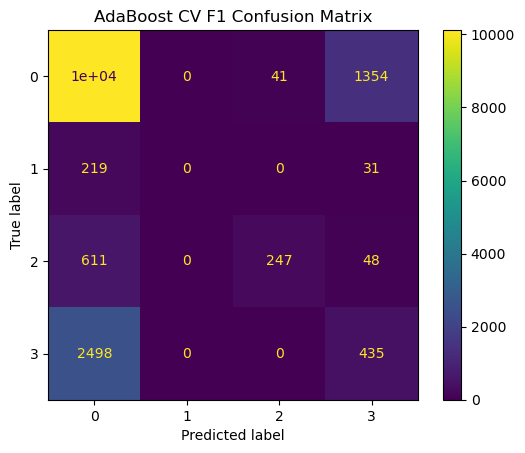

In [164]:
# Storing the GridSearchCV methods from models to grids, to use this later for ROC curve and feature importance.
grids = {}
# Running all the pipelines for each model in models using GridSearchCV.
for model in models:
    if 'params' not in model:
        continue
    pipe = model['pipeline']
    # storing the GridSearchCV method in grids
    grids[model["name"]] = GridSearchCV(
        estimator=pipe,
        param_grid=model['params'],
        scoring=make_scorer(f1_score, average='macro'),
        n_jobs=-1,
        cv=5,
        verbose=5)
    start_time = time.time()
    grids[model["name"]].fit(X_train, y_train)
    end_time = time.time()
    total_train_time = end_time - start_time
    print(f'{model["name"]} GridSearchCV training time: {total_train_time} secs')
    # Storing predict_proba for each model in predict_probas
    predict_probas[f'{model["name"]} CV F1'] = grids[model["name"]].predict_proba(X_test)[:, 1]
    print(grids[model["name"]].best_estimator_)
    # Calculate the average training time per fit iteration
    train_time = total_train_time / grids[model["name"]].cv_results_['mean_fit_time'].shape[0]
    start_time = time.time()
    # Running populate_results to add perf data to model_performance_df
    model_performance_df, y_pred = populate_results(
        f"{model['name']} CV F1", train_time, grids[model["name"]], model_performance_df)
    print(f'{model["name"]} best model prediction and performance metrics time: {time.time() - start_time} secs')

    # Plot the confusion matrix in a new figure
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.title(f'{model["name"]} CV F1 Confusion Matrix')
    plt.savefig(f'images/confusion_matrix_{model["name"]}_CV_F1.png')
    plt.show()

In [165]:
model_performance_df

,Model,Train Time,Train Accuracy %,Test Accuracy %,Train Recall %,Test Recall %,Train Precision %,Test Precision %,Train F1 %,Test F1 %,Train Log Loss,Test Log Loss
0,Logistic,45.986452,74.065705,73.790142,25.000000,25.000000,18.516426,18.447535,21.275215,21.229668,7.580308e-01,0.770026
1,KNN,0.038328,76.671474,70.835203,36.479798,29.527515,63.758846,35.214117,39.422522,29.784935,4.850140e-01,4.206654
2,DecisionTree,0.726964,100.000000,60.143581,100.000000,33.727988,100.000000,32.748697,100.000000,33.177354,2.220446e-16,14.365710
3,RandomForest,2.379498,99.998397,75.456701,99.999459,33.709494,99.992636,81.002396,99.996047,34.672417,1.663664e-01,0.860628
4,GradientBoosting,32.800609,74.921474,74.469585,29.580577,28.312629,89.589841,66.505374,29.434541,27.155757,7.049987e-01,0.739472
5,AdaBoost,0.730222,100.000000,59.925646,100.000000,33.616053,100.000000,32.705326,100.000000,33.103003,1.072796e+00,1.250904
6,GaussianNB,0.013768,72.483974,72.251779,26.055976,25.679831,28.484402,27.437167,23.898909,23.302616,8.204940e-01,0.826925
7,Logistic CV F1,66.528371,74.064103,73.790142,24.999459,25.000000,18.516322,18.447535,21.274950,21.229668,7.583816e-01,0.770649
8,KNN CV F1,0.385467,100.000000,66.143196,100.000000,35.119581,100.000000,35.856626,100.000000,35.135154,2.220446e-16,5.935540
9,DecisionTree CV F1,0.764099,97.620192,61.322992,93.429117,33.110977,98.774988,32.755580,95.971416,32.926571,6.552015e-02,12.964103


In [177]:
predict_probas

{'Logistic': array([0.01342535, 0.00559422, 0.03372036, ..., 0.01178286, 0.01622133,
        0.00472217]),
 'KNN': array([0., 0., 0., ..., 0., 0., 0.]),
 'DecisionTree': array([0., 0., 0., ..., 0., 0., 0.]),
 'RandomForest': array([0.02, 0.03, 0.05, ..., 0.02, 0.01, 0.01]),
 'GradientBoosting': array([0.01220381, 0.01152381, 0.02708464, ..., 0.02679006, 0.0125421 ,
        0.01301478]),
 'AdaBoost': array([0.21931635, 0.21931635, 0.21931635, ..., 0.21931635, 0.21931635,
        0.21931635]),
 'GaussianNB': array([0.00943739, 0.00782501, 0.03315773, ..., 0.01496663, 0.01291852,
        0.00938068]),
 'Logistic CV F1': array([0.01309542, 0.00474251, 0.03528943, ..., 0.01105417, 0.01718916,
        0.0042402 ]),
 'KNN CV F1': array([0., 0., 0., ..., 0., 0., 0.]),
 'DecisionTree CV F1': array([0., 0., 0., ..., 0., 0., 0.]),
 'RandomForest CV F1': array([0.00364177, 0.        , 0.03      , ..., 0.00102957, 0.0005    ,
        0.00013158]),
 'GradientBoosting CV F1': array([0.00265571, 0.001

In [196]:
# %%time
# # Create a figure and axes for plotting
# fig, ax = plt.subplots(figsize=(12, 8))  # Set the size of the figure here

# # Plot ROC curves for various models on the same axes for comparison
# for pipe in pipelines:
#     RocCurveDisplay.from_estimator(pipelines[pipe], X_test, y_test, ax=ax, name=pipe)

# for grid in grids:
#     RocCurveDisplay.from_estimator(grids[grid], X_test, y_test, ax=ax, name=f'{grid} GridSearchCV')

# # Plot a diagonal line to represent a no-skill classifier (baseline)
# ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='baseline')

# # Add a grid for better readability of the plot
# ax.grid()

# # Finalize the plot
# ax.set_title('ROC Curves for Different Models')
# ax.legend()  # This will now include all lines with labels

# # Save and show the plot
# plt.savefig('images/roc_curve.png')
# plt.show()

In [197]:
# roc_areas = {}
# roc_areas['Model'] = list(predict_probas.keys())
# roc_areas['ROC AUC Score'] = []
# roc_areas

In [198]:
# for model in roc_areas['Model']:
#     model.
#     roc_areas['ROC AUC Score'].append(roc_auc_score(y_test, predict_probas[model]))
# roc_areas_df = pd.DataFrame(roc_areas)
# roc_areas_df

In [199]:
# # Create lollipop chart
# plt.figure(figsize=(8, 6))
# plt.stem(roc_areas_df['Model'], roc_areas_df['ROC AUC Score'], basefmt=" ")
# plt.scatter(roc_areas_df['Model'], roc_areas_df['ROC AUC Score'], color='orange', s=100, zorder=3)
# plt.xticks(rotation=45)
# plt.title('ROC AUC Scores of Different Models')
# plt.xlabel('Model')
# plt.ylabel('ROC AUC Score')
# plt.ylim(0.5, 1.0)  # Ensures that the y-axis starts from 0.5 to better visualize the differences
# plt.tight_layout()
# plt.savefig('images/ROC_AUC.png')
# plt.show()

In [170]:
metrics = ['Train Time', 'Test Accuracy %', 'Test Recall %', 'Test Precision %', 'Test F1 %']

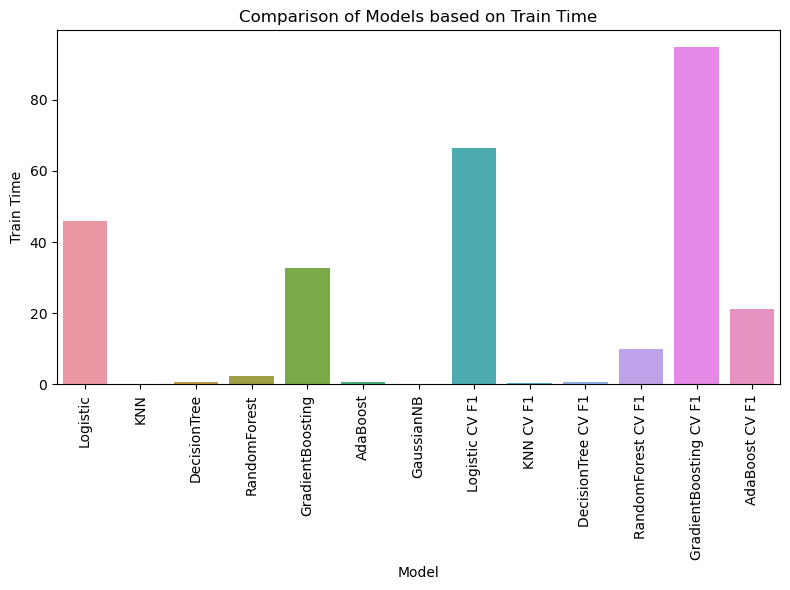

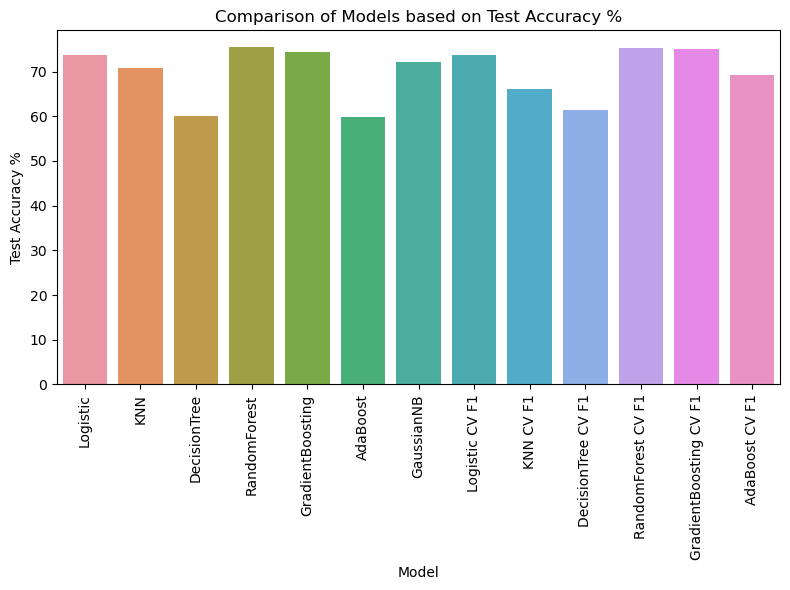

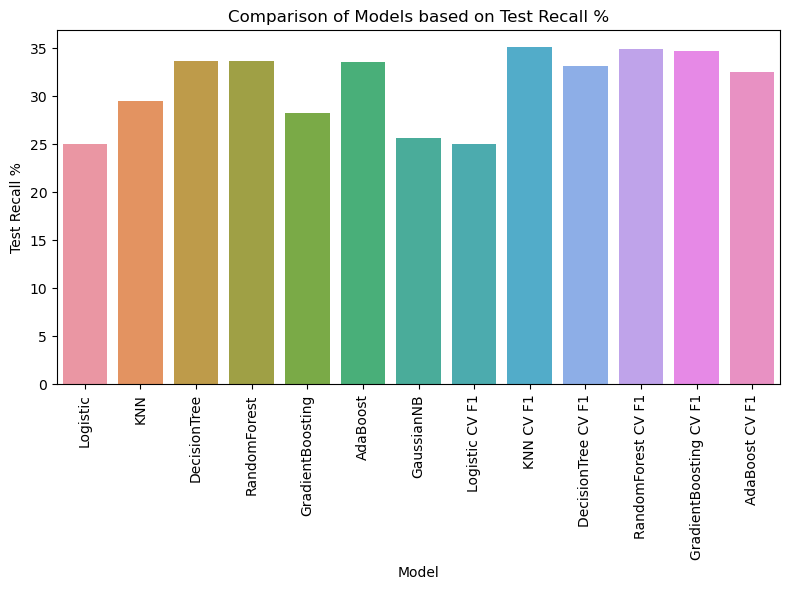

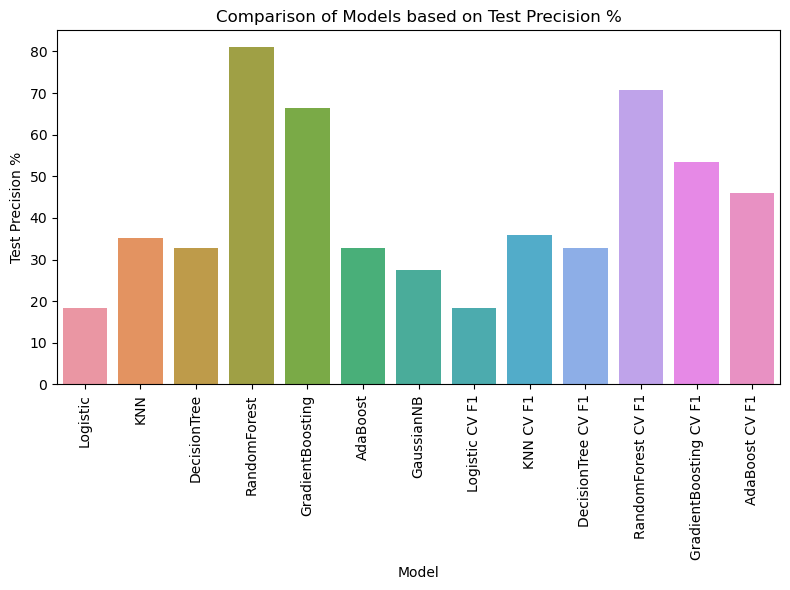

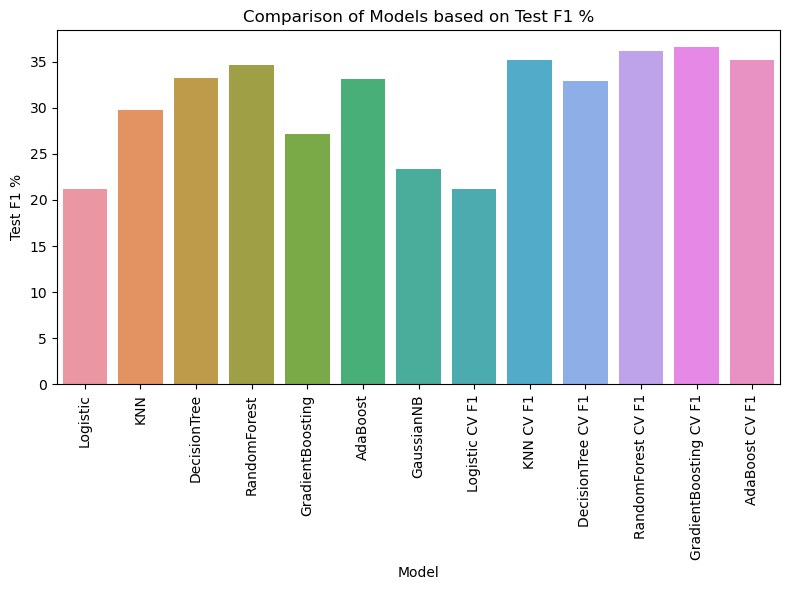

In [171]:
# Loop through each metric listed in the 'metrics' list
for metric in metrics:
    plt.figure(figsize=(8, 6))
    # Create a bar plot to compare different models based on the current metric
    sns.barplot(x='Model', y=metric, data=model_performance_df)
    plt.title(f'Comparison of Models based on {metric}')
    plt.xticks(rotation=90)  # Rotate the model names on x-axis for better visibility
    plt.ylabel(metric)
    plt.tight_layout()
    # Prepare the filename by removing '%' from the metric name, replacing spaces with underscores, and converting to lowercase
    metric_cleaned = metric.lower().replace(" ", "_").replace("%", "")
    
    # Save the plot as an image file with a filename corresponding to the cleaned metric name
    plt.savefig(f'images/models_comp_by_{metric_cleaned}')
    plt.show()

## Feature Importance

In [172]:
# Extract the best Gradient Boosting model from the grid search results.
best_gradient_boosting = grids['GradientBoosting'].best_estimator_.named_steps['model']

# Get the feature importances from the best Gradient Boosting model.
feature_importance = best_gradient_boosting.feature_importances_

# Get the names of the features used in the training data.
features = X_train.columns

# Create a DataFrame to view feature importance, sorting by importance in descending order.
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame to display the feature importance.
print(importance_df)

                             Feature  Importance
2                   shipping_charges    0.190839
5                      payment_value    0.178334
1                              price    0.120658
4              product_category_name    0.115241
0                          seller_id    0.114847
3           customer_zip_code_prefix    0.074607
7                 order_purchase_day    0.064262
9   estimated_delivery_duration_days    0.048140
8               order_purchase_month    0.037754
6                order_purchase_hour    0.030336
10                      vol_category    0.012938
11                   weight_category    0.012043


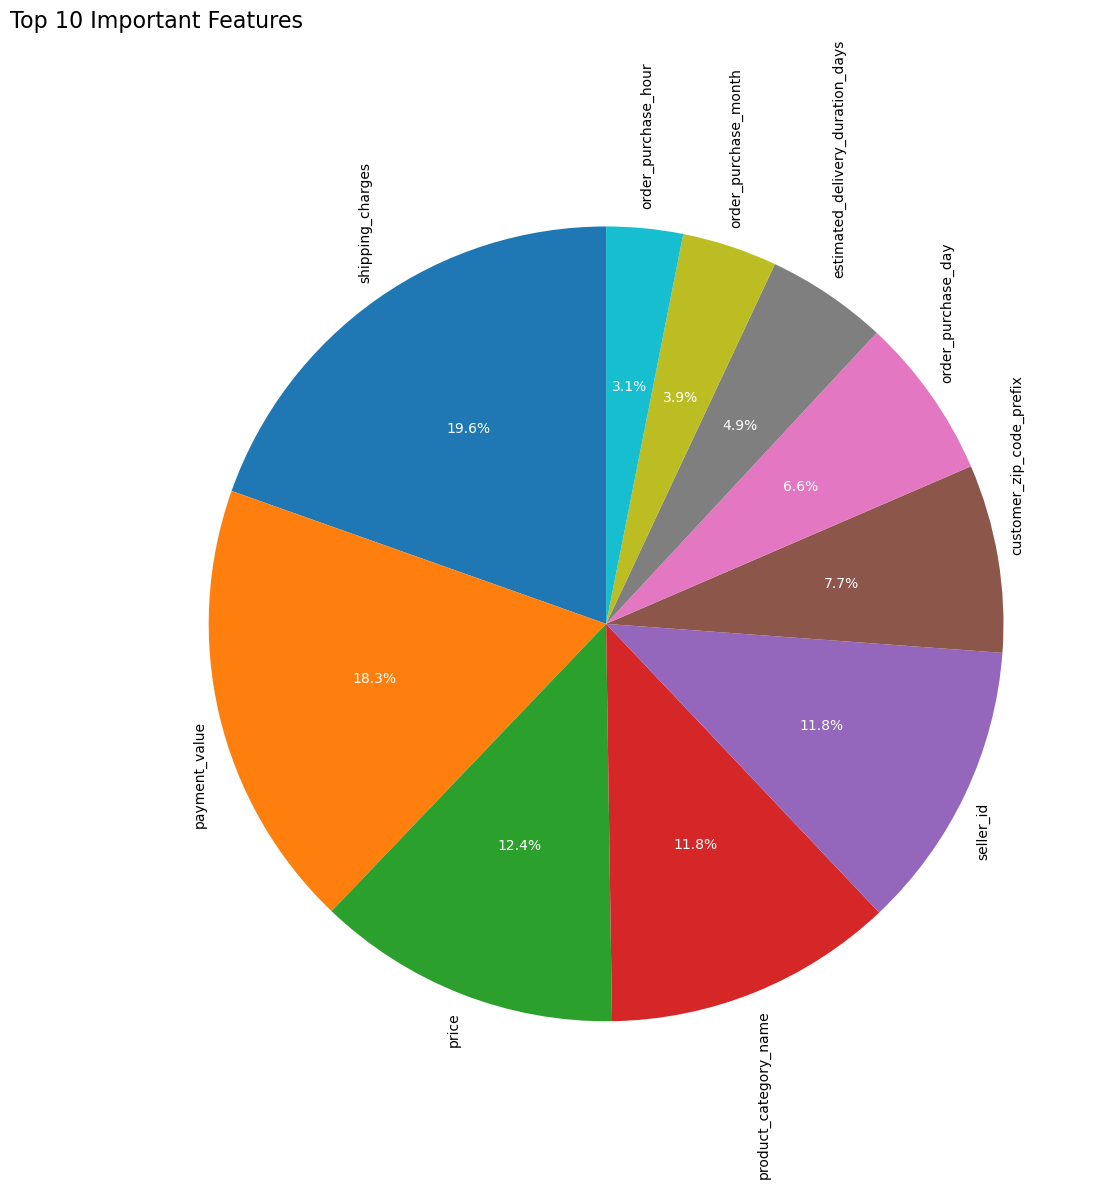

In [173]:
# Select top 10 features
top_10_features = importance_df.head(10)

# Create a pie plot for the top 10 important features
plt.figure(figsize=(16, 12))

# Customize the pie chart to improve label readability
wedges, texts, autotexts = plt.pie(
    top_10_features['Importance'], 
    labels=top_10_features['Feature'], 
    autopct='%1.1f%%', 
    startangle=90,
    labeldistance=1.05,  # Adjust label distance
    rotatelabels=True    # Rotate labels to match the angle of the slice
)

# Customize text properties
for text in texts:
    text.set_rotation(90)  # Rotate text labels
    text.set_horizontalalignment('center')  # Center the text

for autotext in autotexts:
    autotext.set_color('white')  # Change color of percentage text

# Move the title to the top-left corner
plt.text(-1.5, 1.5, 'Top 10 Important Features', fontsize=16, ha='left')
plt.tight_layout()
plt.savefig('images/feature_importances.png')
plt.show()

In [178]:
pipelines

{'Logistic': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('scaler', StandardScaler(),
                                                   ['price', 'shipping_charges',
                                                    'payment_value',
                                                    'estimated_delivery_duration_days'])])),
                 ('model',
                  LogisticRegression(max_iter=10000, multi_class='auto',
                                     n_jobs=-1, random_state=25))]),
 'KNN': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('scaler', StandardScaler(),
                                                   ['price', 'shipping_charges',
                                                    'payment_value',
                                                    'estimated_delivery

In [179]:
grids

{'Logistic': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('scaler',
                                                                          StandardScaler(),
                                                                          ['price',
                                                                           'shipping_charges',
                                                                           'payment_value',
                                                                           'estimated_delivery_duration_days'])])),
                                        ('model',
                                         LogisticRegression(max_iter=10000,
                                                            multi_class='auto',
                                                          

In [193]:
report = {}
for modelname in pipelines:
    model=pipelines[modelname]
    report[modelname] = classification_report(
        digits=6,
        y_true=y_test, 
        y_pred=model.predict(X_test))

    
for modelname in grids:
    model=pipelines[modelname]
    modelname = modelname+"gridsearch"
    report[modelname] = classification_report(
        digits=6,
        y_true=y_test, 
        y_pred=model.predict(X_test))

In [194]:
for modelname in report:
    print(modelname)
    print(report[modelname])

Logistic
              precision    recall  f1-score   support

           0   0.737901  1.000000  0.849187     11512
           1   0.000000  0.000000  0.000000       250
           2   0.000000  0.000000  0.000000       906
           3   0.000000  0.000000  0.000000      2933

    accuracy                       0.737901     15601
   macro avg   0.184475  0.250000  0.212297     15601
weighted avg   0.544499  0.737901  0.626616     15601

KNN
              precision    recall  f1-score   support

           0   0.745952  0.928423  0.827245     11512
           1   0.000000  0.000000  0.000000       250
           2   0.442408  0.186534  0.262422       906
           3   0.220204  0.066144  0.101730      2933

    accuracy                       0.708352     15601
   macro avg   0.352141  0.295275  0.297849     15601
weighted avg   0.617530  0.708352  0.644790     15601

DecisionTree
              precision    recall  f1-score   support

           0   0.756226  0.725417  0.740501     1

In [226]:
orders = df_orders_train[["order_purchase_timestamp", "order_id"]]

In [227]:
orders[[
    "order_purchase_timestamp",
]] = orders[[
    "order_purchase_timestamp",
]].apply(pd.to_datetime)
orders
orders["order_purchase_timestamp"] = orders["order_purchase_timestamp"].dt.date.apply(lambda x: datetime.combine(x, time(0,0,0)))

<Axes: xlabel='order_purchase_timestamp'>

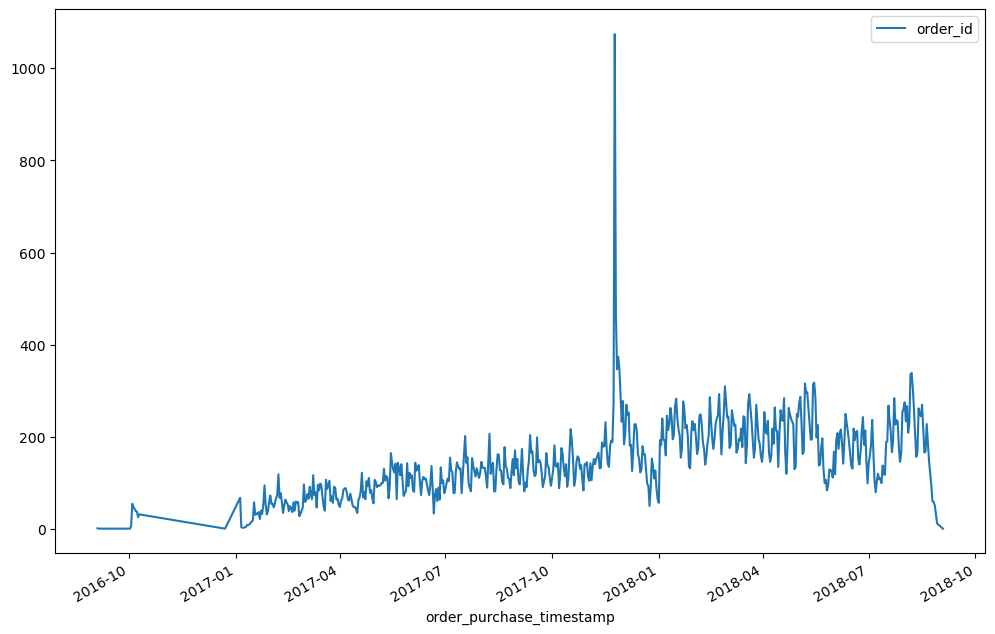

In [228]:
orders.groupby("order_purchase_timestamp").agg({'order_id':'count'}).plot(figsize=(12,8))

Text(0, 0.5, 'frequency')

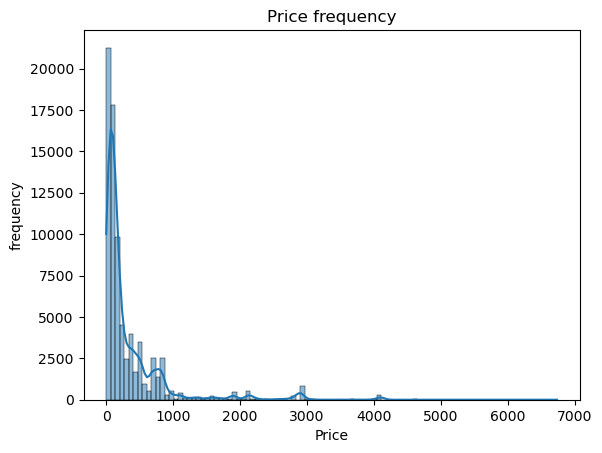

In [231]:
fig = sns.histplot(df["price"], bins=100, kde=True)
# sns.distplot(dt['var'], norm_hist=False, kde=False, bins=3).get_figure()

plt.title("Price frequency")
plt.xlabel("Price")
plt.ylabel("frequency") 

In [233]:
df.groupby("product_category_name").agg("count")

,seller_id,price,shipping_charges,customer_zip_code_prefix,payment_type,payment_value,order_purchase_hour,order_purchase_day,order_purchase_month,estimated_delivery_duration_days,vol_category,weight_category
product_category_name,,,,,,,,,,,,
0.0,59,59,59,59,59,59,59,59,59,59,59,59
1.0,64,64,64,64,64,64,64,64,64,64,64,64
2.0,13,13,13,13,13,13,13,13,13,13,13,13
3.0,4,4,4,4,4,4,4,4,4,4,4,4
4.0,99,99,99,99,99,99,99,99,99,99,99,99
...,...,...,...,...,...,...,...,...,...,...,...,...
65.0,435,435,435,435,435,435,435,435,435,435,435,435
66.0,57,57,57,57,57,57,57,57,57,57,57,57
67.0,821,821,821,821,821,821,821,821,821,821,821,821
